In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from netcal.metrics import ECE, ACE

from dataloader import get_dataloaders
from models.msdnet import MSDNet
from utils import parse_args
from utils_notebook import *

from collections import OrderedDict, Counter
import random
from typing import Dict

import pandas as pd
import glob
import os
import shutil

from tqdm import tqdm
import pickle

/home/metod/miniconda3/envs/msdnet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# torch.set_default_dtype(torch.float64)

# 0.1 ImageNet extract and folder setup

In [3]:
# images = glob.glob("data/image_net/valid/*.JPEG")

# labels = pd.read_csv('data/image_net/valid/labels_kaggle_with_names.csv', index_col=0)
# labels.columns = ["image_id", "label", "name"]

# # make class folders (with names)
# for _name in labels["name"].unique():
#     try:
#         os.mkdir(f'data/image_net/valid/{_name}')
#     except Exception as e:
#         print(i)
#         print(e)

# # extract number from the image name, e.g. 'data/image_net/valid/ILSVRC2012_val_00013964.JPEG' -> 13964
# images_id = [int(image.split('/')[-1].split('.')[0].split('_')[-1]) for image in images]

# # move images to folder labels
# for id, path in zip(images_id, images):
#     label = labels[labels["image_id"] == id]["name"].values[0]
#     name = path.split('/')[-1]
#     try:
#         shutil.move(f'data/image_net/valid/{name}', f'data/image_net/valid/{label}/{name}')
#     except Exception as e:
#         print(id)
#         print(e)

In [9]:
# for label in range(1, 1001):
#     images = glob.glob(f"data/image_net/valid/{label}/*.JPEG")
#     images_id = [int(image.split('/')[-1].split('.')[0].split('_')[-1]) for image in images]
#     for id, path in zip(images_id, images):
#         name = path.split('/')[-1]
#         try:
#             shutil.move(f'data/image_net/valid/{label}/{name}', f'data/image_net/valid/{name}')
#         except Exception as e:
#             print(id)
#             print(e)

In [10]:
# for label in range(1, 1001):
#     os.rmdir(f'/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/data/image_net/valid/{label}')

# 0 load logits

In [2]:
# logits, targets, ARGS = get_logits_targets_image_net()
with open(f'output/ImageNet.p', 'rb') as f:
    data = pickle.load(f)
logits, targets, ARGS = data

In [7]:
# sanity check for labels
for i in range(10):
    print(torch.mode(targets[50*i:50*(i+1)]).values, torch.mode(torch.argmax(logits, dim=2)[-1, :][50*i:50*(i+1)]).values)

tensor(0) tensor(0)
tensor(1) tensor(1)
tensor(2) tensor(2)
tensor(3) tensor(3)
tensor(4) tensor(4)
tensor(5) tensor(5)
tensor(6) tensor(6)
tensor(7) tensor(7)
tensor(8) tensor(8)
tensor(9) tensor(9)


In [8]:
# with open(f'output/{ARGS.data}.p', 'wb') as f:
#     pickle.dump((logits, targets, ARGS), f)
#     f.close()

# 1 Anytime Performance

In [3]:
L = len(logits)
N = logits.shape[1]

In [4]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [8]:
[round(float(x), 4) for x in acc]

[0.5663, 0.6514, 0.6842, 0.6977, 0.7134]

In [8]:
[round(x, 4) for x in modal_probs_decreasing(preds, probs, L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all").values()]

[84.326, 69.972, 51.72, 38.066, 20.518, 14.666, 8.336, 2.024]

In [12]:
probs = torch.softmax(logits, dim=2)
probs_de = probs.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5.])[:, None, None]
preds_de = {i: torch.argmax(probs_de, dim=2)[i, :] for i in range(L)}
acc_de = [(targets == preds_de[i]).sum() / len(targets) for i in range(L)]

In [13]:
logits_poe = logits.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5.])[:, None, None]
probs_poe = torch.softmax(logits_poe, dim=2)
preds_poe = {i: torch.argmax(probs_poe, dim=2)[i, :] for i in range(L)}
acc_poe = [(targets == preds_poe[i]).sum() / len(targets) for i in range(L)]

In [14]:
probs_ovr = ovr_likelihood(logits)
preds_ovr = {i: torch.argmax(probs_ovr, dim=2)[i, :] for i in range(L)}
acc_ovr = [(targets == preds_ovr[i]).sum() / len(targets) for i in range(L)]

In [15]:
probs_ovr = ovr_likelihood(logits)
probs_poe_ovr = f_probs_ovr_poe(probs_ovr)
preds_poe_ovr = {i: torch.argmax(probs_poe_ovr, dim=2)[i, :] for i in range(L)}
acc_poe_ovr = [(targets == preds_poe_ovr[i]).sum() / len(targets) for i in range(L)]

In [16]:
probs_poe_ovr_break_ties = torch.tensor(f_probs_ovr_poe_logits_weighted(logits))
preds_poe_ovr_break_ties = {i: torch.argmax(probs_poe_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties = [(targets == preds_poe_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

In [17]:
# probs_poe_ovr_break_ties_thres_5 = torch.tensor(f_probs_ovr_poe_logits_weighted(logits, threshold=5.0))
# preds_poe_ovr_break_ties_thres_5 = {i: torch.argmax(probs_poe_ovr_break_ties_thres_5, dim=2)[i, :] for i in range(L)}
# acc_poe_ovr_break_ties_thres_5 = [(targets == preds_poe_ovr_break_ties_thres_5[i]).sum() / len(targets) for i in range(L)]

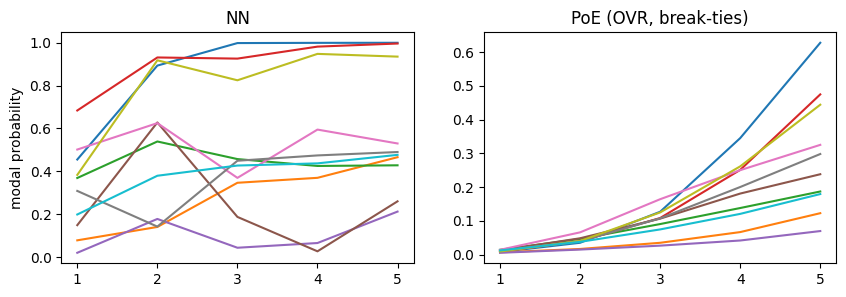

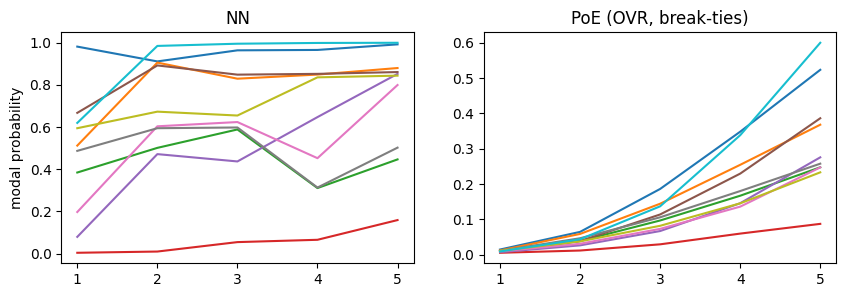

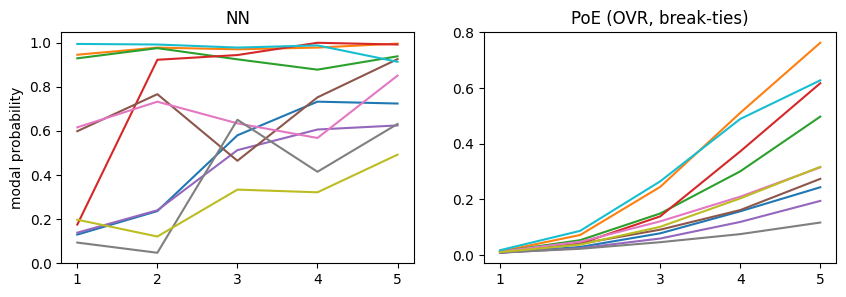

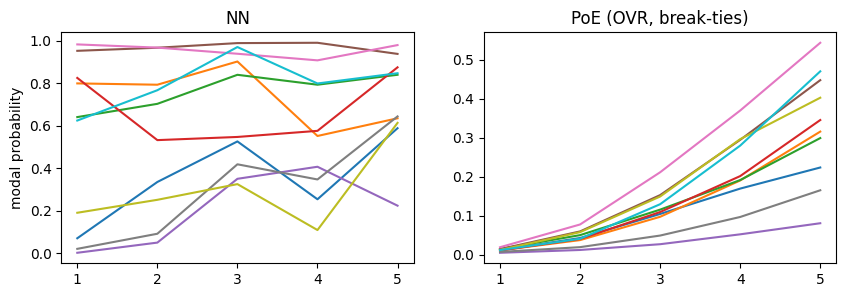

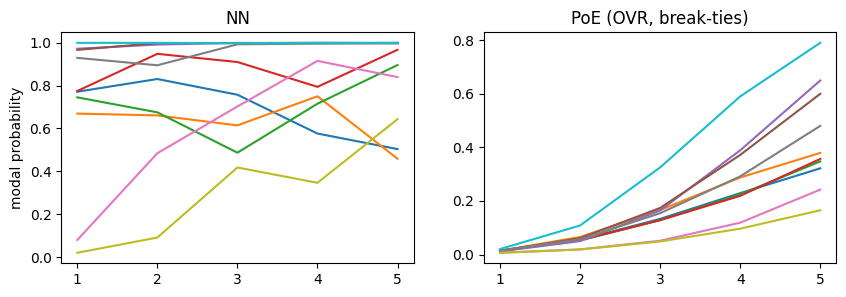

In [16]:
_preds = preds_poe_ovr_break_ties[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs_poe_ovr_break_ties

for _ in range(5):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    samples = random.sample(range(N), 10)
    for i in samples:
        probs_i = _probs[:, i, _preds[i]].cpu()
        probs_i_baseline = probs[:, i, preds[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i_baseline) + 1)), probs_i_baseline, label=f'{i}');
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    # plt.legend()
    ax[0].set_title('NN')
    ax[1].set_title('PoE (OVR, break-ties)')
    ax[0].set_ylabel('modal probability')
    plt.show()

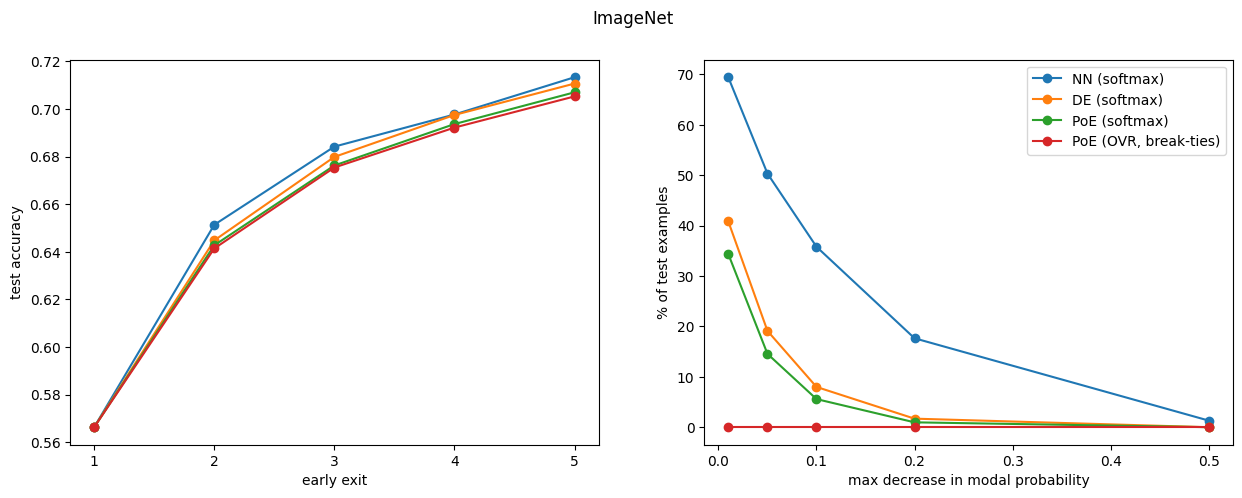

In [17]:
early_exits = [i + 1 for i in range(len(acc))]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(early_exits, acc, label='NN (softmax)', marker='o',)
ax[0].plot(early_exits, acc_de, label='DE (softmax)', marker='o')
ax[0].plot(early_exits, acc_poe, label='PoE (softmax)', marker='o')
ax[0].plot(early_exits, acc_poe_ovr_break_ties, label='PoE (OVR, break-ties)', marker='o')
# ax[0].plot(early_exits, acc_poe_ovr, label='PoE (OVR)', marker='o')
ax[0].set_xlabel('early exit')
ax[0].set_ylabel('test accuracy')
ax[0].set_xticks([1., 2., 3., 4., 5.], [1, 2, 3, 4, 5])

for _preds, _probs, label in [
                            (preds, probs, 'NN (softmax)'), 
                            (preds_de, probs_de, 'DE (softmax)'), 
                            (preds_poe, probs_poe, 'PoE (softmax)'),
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'PoE (OVR, break-ties)'),
                            # (preds_poe_ovr, probs_poe_ovr, 'PoE (OVR)'),
                            # (preds_ovr_break_ties, probs_ovr_break_ties, 'NN (OVR, break-ties)'),
                            # (preds_poe_ovr_fallback_ood, probs_poe_ovr_fallback_ood, 'PoE (OVR, fall-back)')
                            ]:
    modal_probs = modal_probs_decreasing(_preds, _probs, L, N=N)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
ax[1].legend()
# ax[1].set_title('anytime-prediction')
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')


plt.suptitle('ImageNet')
plt.show()

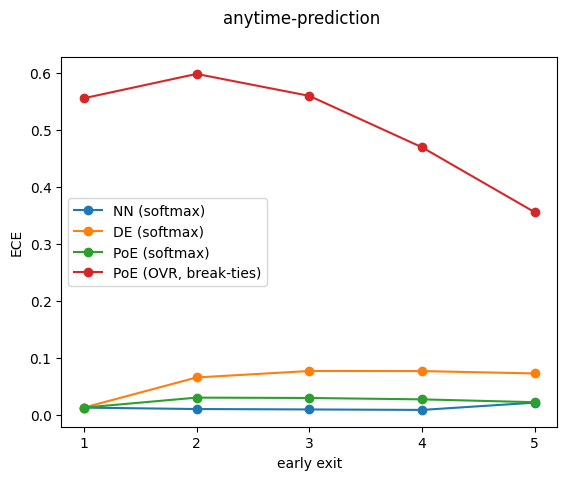

In [18]:
early_exits = [i + 1 for i in range(len(acc))]
for _probs, label in [
                      (probs, 'NN (softmax)'),  
                      (probs_de, 'DE (softmax)'), 
                      (probs_poe, 'PoE (softmax)'),
                      # (probs_poe_ovr, 'PoE (OVR)'),
                      (probs_poe_ovr_break_ties, 'PoE (OVR, break-ties)'),
                      # (probs_poe_ovr_break_ties_thres_5, 'PoE (OVR, break-ties, thres=5)'),
                      # (probs_poe_ovr_fallback_ood, 'PoE (OVR, fall-back)')
                      ]:
    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
    plt.plot(early_exits, ece, marker='o', label=label)
plt.legend()
plt.xlabel('early exit')
plt.ylabel('ECE')
plt.xticks([1., 2., 3., 4., 5.], [1, 2, 3, 4, 5])

plt.suptitle('anytime-prediction')
plt.show()

In [19]:
(torch.stack(acc)[1:] / torch.stack(acc)[:-1]) - 1.

tensor([0.1502, 0.0504, 0.0197, 0.0224])

# 2 Predictive set size

In [20]:
N = len(targets)
THRES = [0., 1., 2., 3., 4., 5.]

In [21]:
thres_dict = {}
for thres in tqdm(THRES):
    _probs = torch.tensor(f_probs_ovr_poe_logits_weighted(logits, threshold=thres))
    _preds = {i: torch.argmax(_probs, dim=2)[i, :] for i in range(L)}
    _acc = [(targets == _preds[i]).sum() / len(targets) for i in range(L)]

    groud_truth_coverage = {l: 0 for l in range(L)}
    predictive_set_size = {l: [] for l in range(L)}
    for l in range(L):
        for n in range(N):
            if _probs[l, n, targets[n]] > 0.:
                groud_truth_coverage[l] += 1
            predictive_set_size[l].append((_probs[l, n, :] > 0).sum())

    predictive_set_size = {l: torch.stack(sizes, dim=0) for l, sizes in predictive_set_size.items()}
    predictive_set_size_mean = {l: sizes.numpy().mean() for l, sizes in predictive_set_size.items()}
    groud_truth_coverage_pct = {l: (x / N) for l, x in groud_truth_coverage.items()}
    thres_dict[thres] = (groud_truth_coverage_pct, predictive_set_size_mean, _acc)

 50%|█████     | 3/6 [00:39<00:39, 13.08s/it]/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/utils_notebook.py:114: RuntimeWarning: invalid value encountered in divide
  probs = (probs / np.repeat(probs.sum(axis=2)[:, :, np.newaxis], C, axis=2))
100%|██████████| 6/6 [01:20<00:00, 13.39s/it]


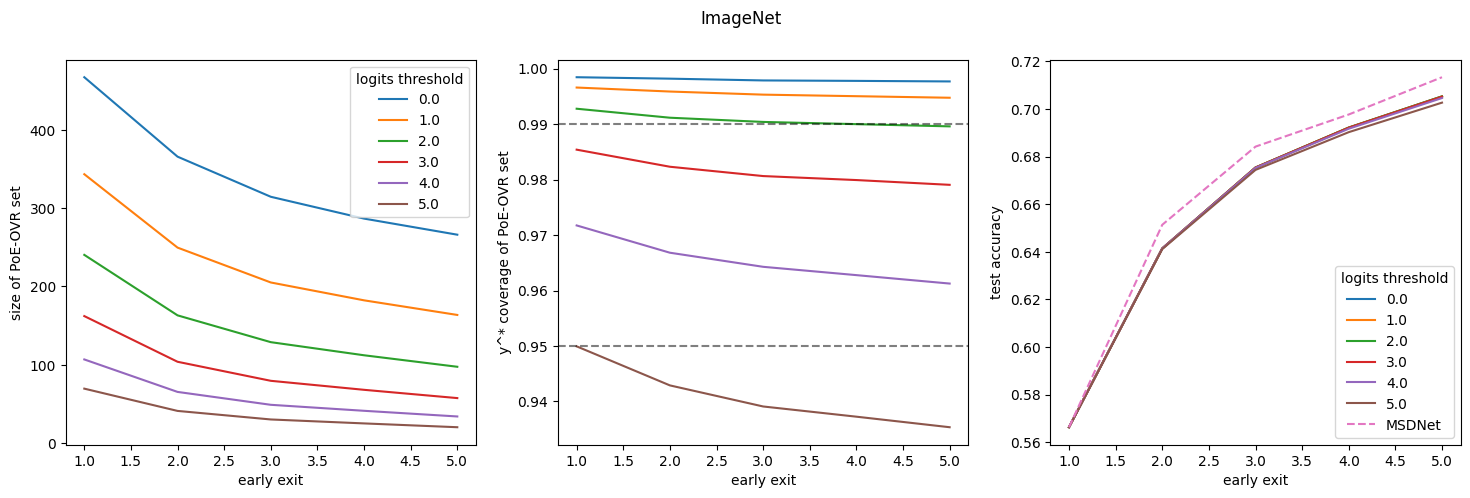

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
for thres in THRES:
    ax[0].plot([x + 1 for x in thres_dict[thres][1].keys()], list(thres_dict[thres][1].values()), label=thres)
    ax[1].plot([x + 1 for x in thres_dict[thres][0].keys()], list(thres_dict[thres][0].values()), label=thres)
    ax[2].plot([x + 1 for x in thres_dict[thres][0].keys()], thres_dict[thres][2], label=thres)
ax[2].plot([x + 1 for x in thres_dict[thres][0].keys()], acc, label='MSDNet', linestyle='--')
ax[0].legend(title='logits threshold')
ax[2].legend(title='logits threshold')
ax[0].set_ylabel('size of PoE-OVR set')
ax[1].set_ylabel('y^* coverage of PoE-OVR set')
ax[2].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')
ax[1].set_xlabel('early exit')
ax[2].set_xlabel('early exit')

ax[1].axhline(y=0.99, color='black', linestyle='--', alpha=0.5)
ax[1].axhline(y=0.95, color='black', linestyle='--', alpha=0.5)
plt.suptitle(ARGS.data)
plt.show()

# 3 Generalized PoE

In [5]:
# probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=np.array([1. ,2., 3., 4., 5.])))
T = 1.
probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.array([1. ,2., 3., 4., 5.]) / 5.)) * T)
preds_poe_ovr_break_ties_generalized = {i: torch.argmax(probs_poe_ovr_break_ties_generalized, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized = [(targets == preds_poe_ovr_break_ties_generalized[i]).sum() / len(targets) for i in range(L)]

In [10]:
[round(float(x), 4) for x in acc_poe_ovr_break_ties_generalized]

[0.5663, 0.6508, 0.6867, 0.7022, 0.7138]

In [14]:
[round(x, 4) for x in modal_probs_decreasing(preds_poe_ovr_break_ties_generalized, 
                                            probs_poe_ovr_break_ties_generalized, L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all").values()]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

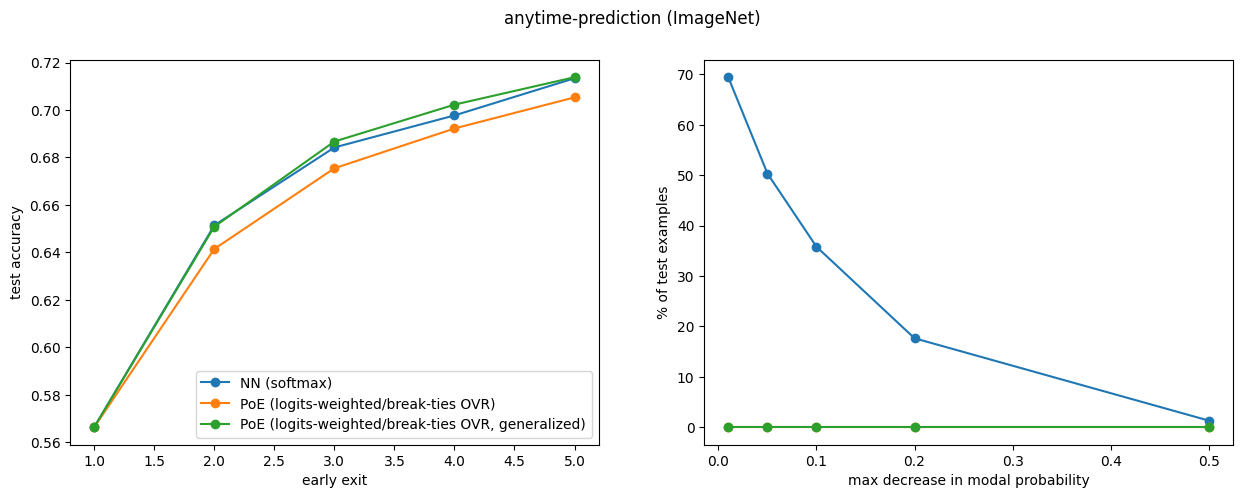

In [24]:
early_exits = [i + 1 for i in range(len(acc))]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(early_exits, acc, label='NN (softmax)', marker='o',)
ax[0].plot(early_exits, acc_poe_ovr_break_ties, label='PoE (logits-weighted/break-ties OVR)', marker='o')
ax[0].plot(early_exits, acc_poe_ovr_break_ties_generalized, label='PoE (logits-weighted/break-ties OVR, generalized)', marker='o')
ax[0].legend()
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

for _preds, _probs, label in [
                            (preds, probs, 'NN (softmax)'), 
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'PoE (logits-weighted/break-ties OVR)'),
                            (preds_poe_ovr_break_ties_generalized, probs_poe_ovr_break_ties_generalized, 'PoE (logits-weighted/break-ties OVR, generalized)'),
                            ]:
    modal_probs = modal_probs_decreasing(_preds, _probs, L, N=N)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')


plt.suptitle(f'anytime-prediction ({ARGS.data})')
plt.show()

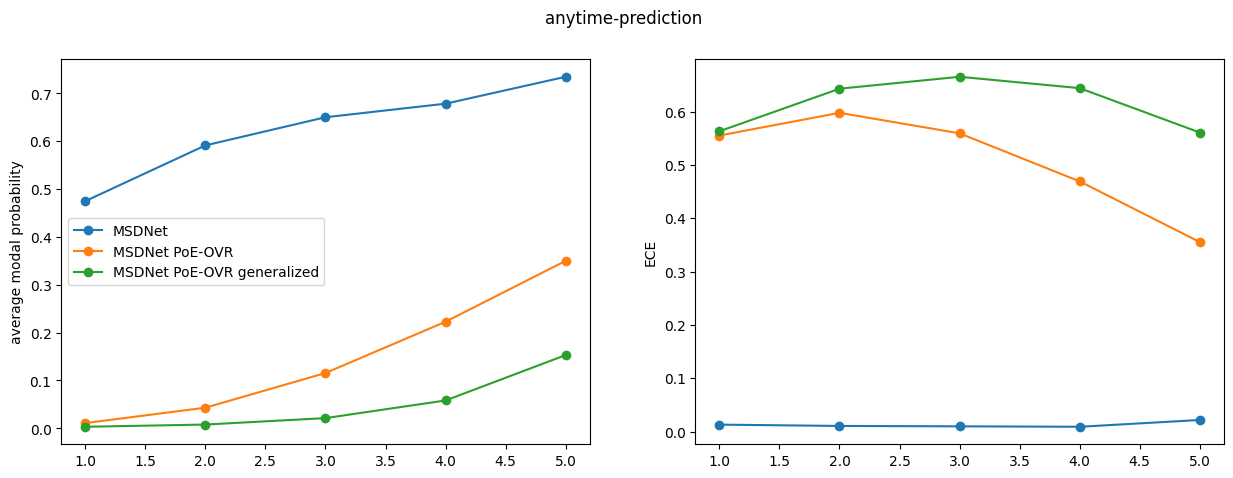

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
early_exits = [i + 1 for i in range(len(acc))]
for _preds, _probs, label in [
                            (preds, probs, 'MSDNet'), 
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'MSDNet PoE-OVR'),
                            (preds_poe_ovr_break_ties_generalized, probs_poe_ovr_break_ties_generalized, 'MSDNet PoE-OVR generalized'),
                            ]:
    modal_probs = modal_probs_average(_preds, _probs, L, N=N)
    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
    ax[0].plot(early_exits, modal_probs.numpy(), marker='o', label=label)
    ax[1].plot(early_exits, ece, marker='o', label=label)
ax[0].legend()
ax[0].set_ylabel('average modal probability')
ax[1].set_ylabel('ECE')


plt.suptitle('anytime-prediction')
plt.show()

# 4 Temperature scaling

In [26]:
T_ARR = [ 0.2, 0.5, 1., 2., 5.]
PROBS_NAME = ['MSDNet', 'MSDNet PoE-OVR']
PROBS = [probs, probs_poe_ovr_break_ties_generalized]

In [27]:
scaled_dict = get_scale_probs(PROBS_NAME, PROBS, T_ARR, targets, C=ARGS.num_classes, L=L)

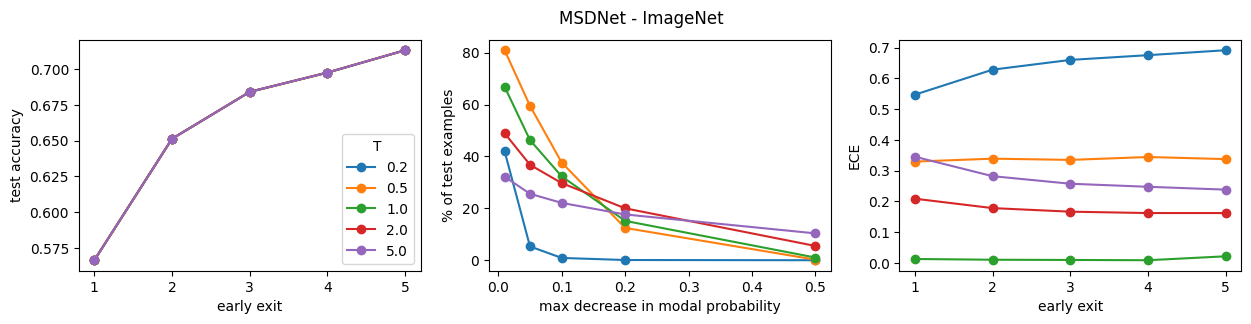

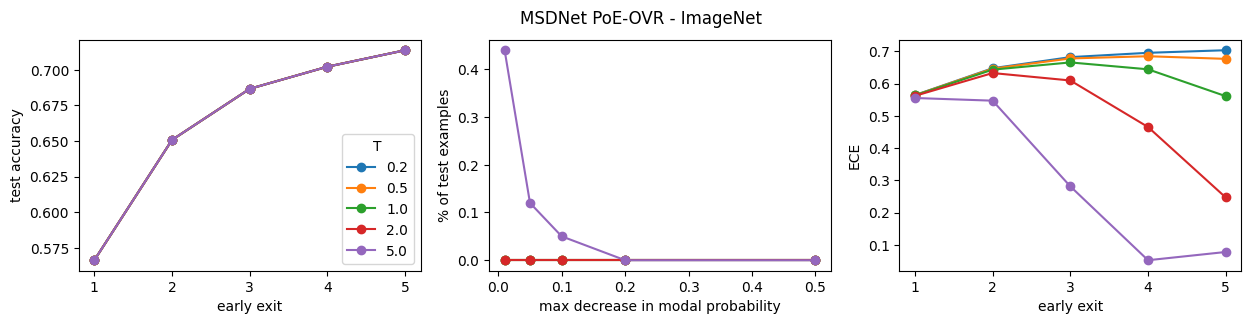

In [28]:
for prob_name in PROBS_NAME:
    fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    for i, T in enumerate(T_ARR):
        _probs, _preds, _acc = scaled_dict[prob_name][T]
        ax[0].plot(list(range(1, L + 1)), _acc, label=T, marker='o')
        ax[0].set_xlabel('early exit')
        ax[0].set_ylabel('test accuracy')
        ax[0].legend(title='T')

        modal_probs = modal_probs_decreasing(_preds, _probs, L)
        ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)

        ax[1].set_xlabel('max decrease in modal probability')
        ax[1].set_ylabel('% of test examples')

        ece = []
        for l in range(L):
            ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
        ax[2].plot(list(range(1, L + 1)), ece, marker='o', label=label)
        ax[2].set_xlabel('early exit')
        ax[2].set_ylabel('ECE')
        
    plt.suptitle(f'{prob_name} - {ARGS.data}')
    plt.show()

# 5 Sort images w.r.t. entropy/MSP (hard vs easy examples)

In [10]:
val_loader = get_image_net_val_loader(ARGS, normalize=False)

LABEL = 0

label_ids = np.where(targets.numpy() == LABEL)[0]
val_images, val_targets = next(iter(val_loader))
val_images, val_targets = val_images[label_ids], val_targets[label_ids]

In [28]:
l = 0
easy_vs_hard = probs[l, label_ids, :].max(dim=1).values.argsort().numpy()
easy_vs_hard_poe_ovr_break_ties_generalized = probs_poe_ovr_break_ties_generalized[l, label_ids, :].max(dim=1).values.argsort().numpy()

In [29]:
easy_vs_hard

array([ 2, 32, 35, 36, 31, 29, 27,  0, 20,  1, 10, 21,  4, 48, 25, 42,  6,
       19, 26, 46, 41,  3,  7, 43, 37, 45, 38,  5, 23, 34,  8, 13,  9, 18,
       14, 22, 39, 44, 30, 40, 49, 11, 33, 24, 47, 28, 12, 15, 17, 16])

In [30]:
probs[l, label_ids, :].max(dim=1).values.sort().values.numpy()

array([0.08368771, 0.12604095, 0.15075223, 0.2958613 , 0.30850706,
       0.44555655, 0.45077038, 0.47960818, 0.52567804, 0.56073606,
       0.6132172 , 0.6866294 , 0.7437559 , 0.81484747, 0.8262277 ,
       0.84025866, 0.8433354 , 0.8478345 , 0.8629197 , 0.8676097 ,
       0.9237862 , 0.92554903, 0.9289144 , 0.9315646 , 0.94988054,
       0.9577057 , 0.96246433, 0.9627378 , 0.96640456, 0.96865654,
       0.97582245, 0.97702163, 0.9788786 , 0.985686  , 0.9904587 ,
       0.9917286 , 0.9941869 , 0.994693  , 0.9954347 , 0.9973239 ,
       0.9980919 , 0.99861765, 0.99886227, 0.9989422 , 0.9989735 ,
       0.9991543 , 0.9993623 , 0.9995541 , 0.9996427 , 0.99965656],
      dtype=float32)

In [31]:
((preds[l][label_ids] == targets[label_ids])[easy_vs_hard]).type(torch.uint8)

tensor([0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1], dtype=torch.uint8)

In [32]:
easy_vs_hard_poe_ovr_break_ties_generalized

array([ 2, 35, 32, 27, 31, 25, 42, 20, 29, 19,  4, 39, 37, 45, 41, 36,  3,
       46, 10, 33, 28, 21,  6,  5, 48, 43,  0, 38,  1,  7, 30, 34, 14, 47,
       11,  9, 40, 17, 49,  8, 16, 13, 12, 15, 23, 26, 18, 22, 44, 24])

In [33]:
probs_poe_ovr_break_ties_generalized[l, label_ids, :].max(dim=1).values.sort().values.numpy()

array([0.00274783, 0.00280792, 0.0028232 , 0.00282505, 0.00287534,
       0.002894  , 0.00290375, 0.00292461, 0.00301385, 0.00304237,
       0.00307279, 0.0030787 , 0.00309628, 0.00309685, 0.00311136,
       0.00311743, 0.00312664, 0.00312852, 0.0031808 , 0.00321531,
       0.0032202 , 0.00322164, 0.00323174, 0.00323717, 0.00324612,
       0.00325735, 0.00325942, 0.00326826, 0.00330614, 0.00332518,
       0.00334835, 0.00334955, 0.00335218, 0.00335834, 0.00335911,
       0.00338288, 0.00338372, 0.00339372, 0.00339438, 0.00340015,
       0.00343594, 0.0034898 , 0.00350737, 0.00352034, 0.00357223,
       0.00359341, 0.00360267, 0.00361041, 0.00368311, 0.00378786],
      dtype=float32)

In [34]:
((preds_poe_ovr_break_ties_generalized[l][label_ids] == targets[label_ids])[easy_vs_hard_poe_ovr_break_ties_generalized]).type(torch.uint8)

tensor([0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1], dtype=torch.uint8)

In [1]:
# for i in range(len(easy_vs_hard)):
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     ax[0].imshow(val_images[easy_vs_hard[i], :, :, :].cpu().permute(1, 2, 0))
#     ax[0].axis('off')
#     ax[0].set_title('base')
#     ax[1].imshow(val_images[easy_vs_hard_poe_ovr_break_ties_generalized[i], :, :, :].cpu().permute(1, 2, 0))
#     ax[1].axis('off')
#     ax[1].set_title('PoE-OVR')
#     plt.suptitle(f'hardness ranking: {i + 1}')
#     plt.show()

# 6 nr. of early exits that equal final prediction

In [15]:
# preds_ = torch.stack([preds[l] == preds[L - 1] for l in range(L - 1)], dim=0).int().sum(dim=0).numpy()
preds_ = torch.stack([preds[l] == targets for l in range(L)], dim=0).int().sum(dim=0).numpy()
preds_unique, preds_counts = np.unique(preds_, return_counts=True)

In [16]:
# preds_poe_ovr_ = torch.stack([preds_poe_ovr_break_ties_generalized[l] == preds_poe_ovr_break_ties_generalized[L - 1] for l in range(L - 1)], dim=0).int().sum(dim=0).numpy()
preds_poe_ovr_ = torch.stack([preds_poe_ovr_break_ties_generalized[l] == targets for l in range(L)], dim=0).int().sum(dim=0).numpy()
preds_poe_ovr_unique, preds_poe_ovr_counts = np.unique(preds_poe_ovr_, return_counts=True)

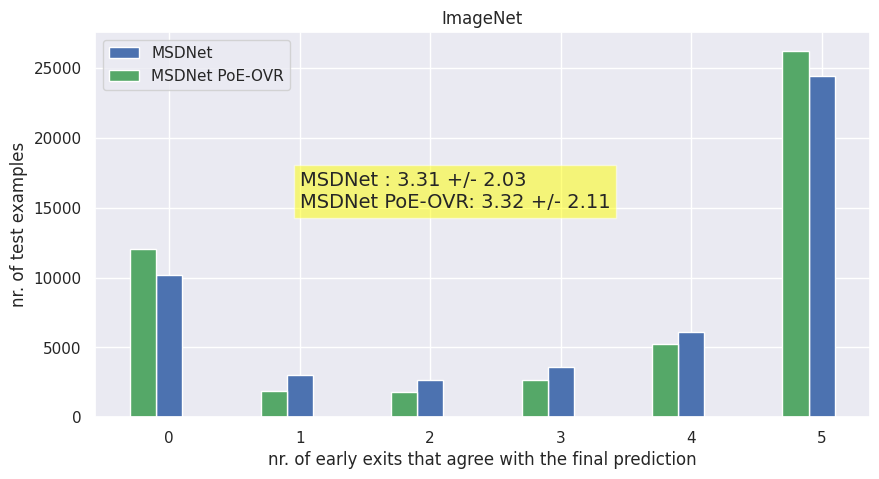

In [17]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(preds_unique, preds_counts, label='MSDNet', width=0.2, color='b', align='center',)
ax.bar(preds_poe_ovr_unique - 0.2, preds_poe_ovr_counts, label='MSDNet PoE-OVR', width=0.2, color='g', align='center')
# plt.xticks(x, [1, 2, 3])
plt.legend()
plt.xlabel('nr. of early exits that agree with the final prediction')
plt.ylabel('nr. of test examples')
plt.text(1, 15000, f'MSDNet : {preds_.mean():.2f} +/- {preds_.std():.2f}\nMSDNet PoE-OVR: {preds_poe_ovr_.mean():.2f} +/- {preds_poe_ovr_.std():.2f}', fontsize = 14, 
         bbox = dict(facecolor = 'yellow', alpha = 0.5))
plt.title(f'{ARGS.data}')
plt.show()

In [18]:
scipy.stats.wilcoxon(preds_, preds_poe_ovr_, alternative='less')

WilcoxonResult(statistic=16982235.5, pvalue=0.002965656760104045)

# 7 Changing your mind

In [11]:
preds_change = torch.stack([x for x in preds.values()], dim=0)
preds_change = (L - 1) - (preds_change[1:, :] == preds_change[:-1, :]).sum(dim=0).numpy()
preds_change_unique, preds_change_counts = np.unique(preds_change, return_counts=True)

In [12]:
preds_poe_ovr_change = torch.stack([x for x in preds_poe_ovr_break_ties_generalized.values()], dim=0)
preds_poe_ovr_change = (L - 1) - (preds_poe_ovr_change[1:, :] == preds_poe_ovr_change[:-1, :]).sum(dim=0).numpy()
preds_poe_ovr_change_unique, preds_poe_ovr_change_counts = np.unique(preds_poe_ovr_change, return_counts=True)

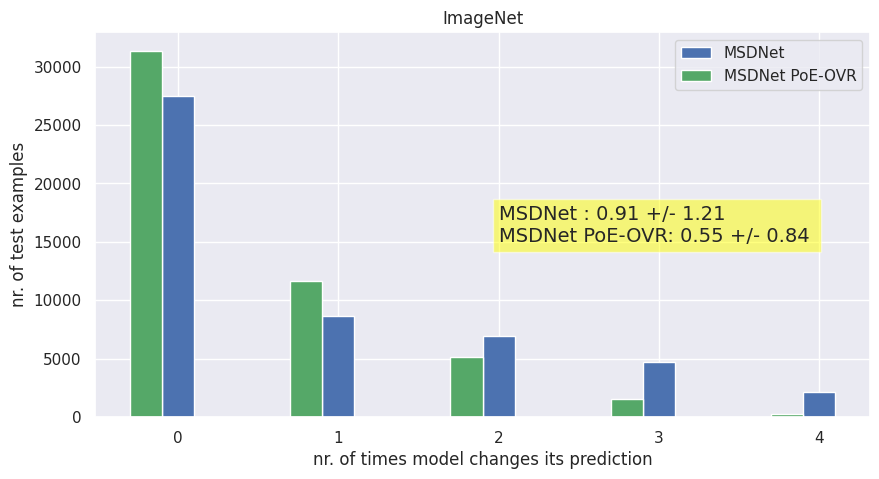

In [15]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(preds_change_unique, preds_change_counts, label='MSDNet', width=0.2, color='b', align='center',)
ax.bar(preds_poe_ovr_change_unique - 0.2, preds_poe_ovr_change_counts, label='MSDNet PoE-OVR', width=0.2, color='g', align='center')
# plt.xticks(x, [1, 2, 3])
plt.legend()
plt.xlabel('nr. of times model changes its prediction')
plt.ylabel('nr. of test examples')
plt.text(2, 15000, f'MSDNet : {preds_change.mean():.2f} +/- {preds_change.std():.2f} \nMSDNet PoE-OVR: {preds_poe_ovr_change.mean():.2f} +/- {preds_poe_ovr_change.std():.2f} ', fontsize = 14, 
         bbox = dict(facecolor = 'yellow', alpha = 0.5))
plt.title(f'{ARGS.data}')
plt.show()

5

In [12]:
preds_change_targets = torch.stack([x == targets for x in preds.values()], dim=0)
preds_change_targets = preds_change_targets.int().diff(dim=0).numpy()

In [13]:
preds_poe_ovr_change_targets = torch.stack([x == targets for x in preds_poe_ovr_break_ties_generalized.values()], dim=0)
preds_poe_ovr_change_targets = preds_poe_ovr_change_targets.int().diff(dim=0).numpy()

In [14]:
res_dict = change_your_mind_analysis(['base', 'PoE-OvR'], [preds_change_targets, preds_poe_ovr_change_targets], [preds[L - 1], preds_poe_ovr_break_ties_generalized[L - 1]], targets, N)

In [15]:
res_dict

{'base': {'no_change (corr_pred)': 24423,
  'no_change (incorr_pred)': 10193,
  'corr_to_incorr': 7845,
  'incorr_to_corr': 1393,
  'both': 6146},
 'PoE-OvR': {'no_change (corr_pred)': 26267,
  'no_change (incorr_pred)': 12044,
  'corr_to_incorr': 8430,
  'incorr_to_corr': 1240,
  'both': 2019}}

In [22]:
print('% of test cases with good changing-your-mind trajectories')
print('base: ', 100 * (res_dict['base']['no_change (corr_pred)'] + res_dict['base']['incorr_to_corr']) / N)
print('PoE-OvR: ', 100 * (res_dict['PoE-OvR']['no_change (corr_pred)'] + res_dict['PoE-OvR']['incorr_to_corr']) / N)

% of test cases with good changing-your-mind trajectories
base:  51.632
PoE-OvR:  55.014


# 8 Misc

## 8.1 Plot ImageNet

In [29]:
# for j, (x, y) in enumerate(val_loader):
#     # plot test images
#     for i in range(10):
#         plt.imshow(x[i, :, :, :].cpu().permute(1, 2, 0))
#         plt.title(f'{y[i]}')
#         plt.axis('off')
#         plt.show()
#     if j > 1:
#         break

# 9 Oracle model

In [14]:
# _probs = probs
# _preds = preds
# _acc = acc

# _probs = probs_poe_ovr_break_ties_generalized
# _preds = preds_poe_ovr_break_ties_generalized
# _acc = acc_poe_ovr_break_ties_generalized

oracle_dict = {}
for name, _preds, _acc in zip(['base', 'PoE-OvR'], [preds, preds_poe_ovr_break_ties_generalized], [acc, acc_poe_ovr_break_ties_generalized]):
    incorrect_ids = []
    correct_ids = []
    for n in range(N):
        preds_all = [_preds[l][n] for l in range(L)]
        if targets[n] in preds_all:
            correct_ids.append((n, preds_all.index(targets[n])))
        else:
            incorrect_ids.append(n)
    
    print(len(correct_ids) / N, float(_acc[-1]), float(len(correct_ids)  / N - _acc[-1]))
    assert len(correct_ids) + len(incorrect_ids) == N

    oracle_dict[name] = (correct_ids, incorrect_ids)


0.79614 0.7133600115776062 0.08278000354766846
0.75912 0.7138000130653381 0.045319974422454834


In [23]:
exits_of_oracle = [x[1] + 1 for x in oracle_dict['base'][0]]
sorted(Counter(exits_of_oracle).items()), np.mean(exits_of_oracle)

([(1, 28316), (2, 6412), (3, 2866), (4, 1298), (5, 915)], 1.4948375913784009)

In [24]:
exits_of_oracle = [x[1] + 1 for x in oracle_dict['PoE-OvR'][0]]
sorted(Counter(exits_of_oracle).items()), np.mean(exits_of_oracle)

([(1, 28316), (2, 5427), (3, 2292), (4, 1160), (5, 761)], 1.4356359995784593)

In [54]:
problematic_ids = [x for x in oracle_dict['PoE-OvR'][1] if x not in oracle_dict['base'][1]]
cool_ids = [x for x in oracle_dict['base'][1] if x not in oracle_dict['PoE-OvR'][1]]

In [55]:
len(problematic_ids), len(cool_ids)

(2021, 170)

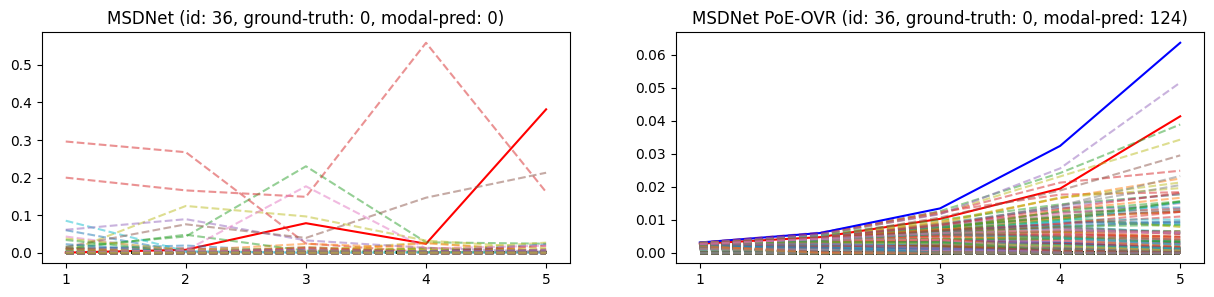

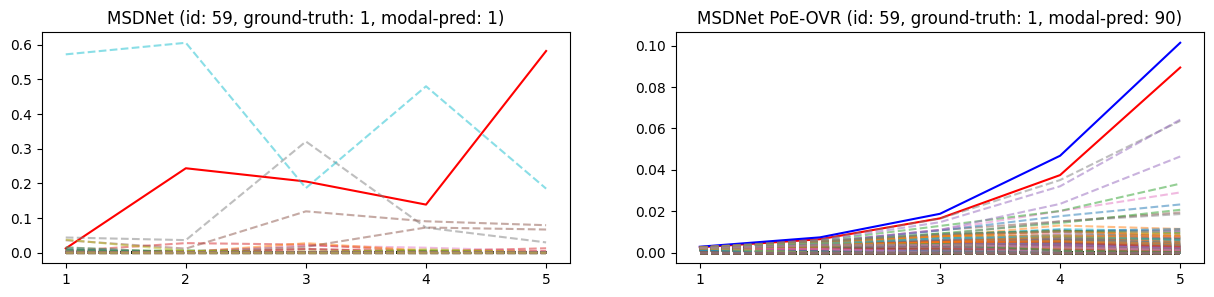

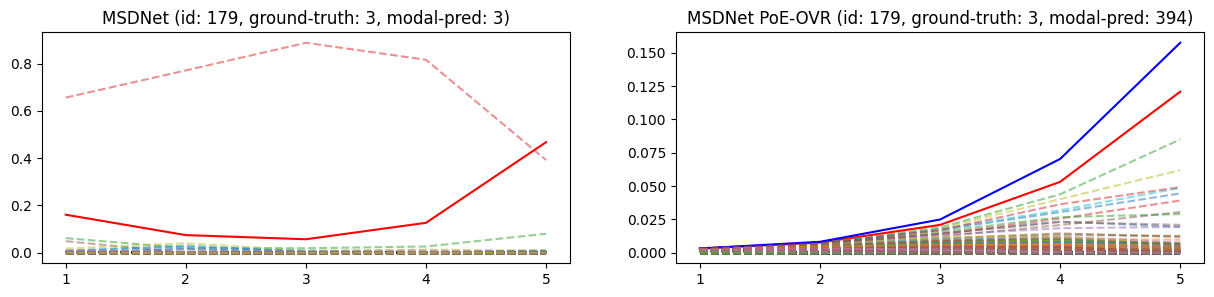

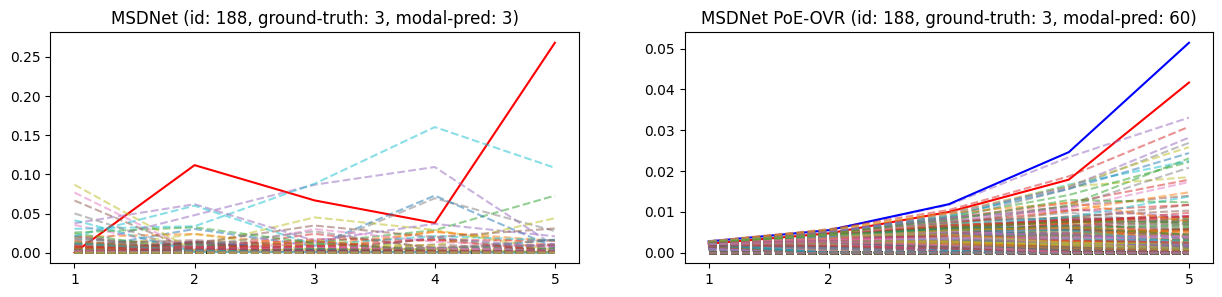

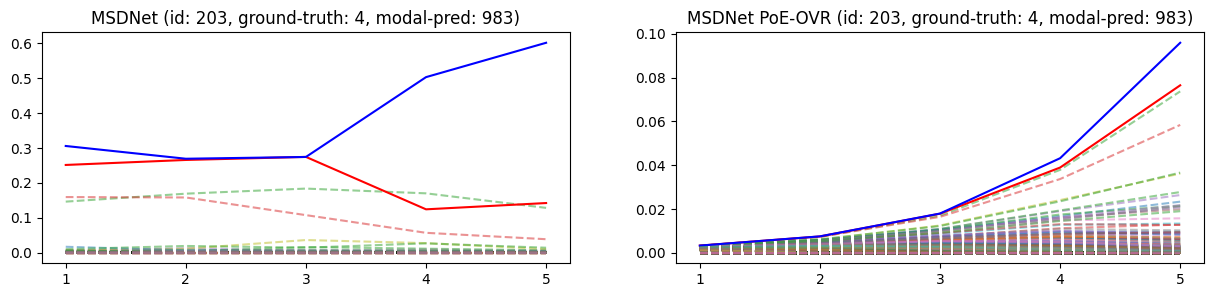

In [70]:
for i in problematic_ids[:5]:
# for i in cool_ids[:3]:
    early_exits = [l for l in range(1, L + 1)]
    fig, ax = plt.subplots(1, 2, figsize=(15, 3))
    # print(targets[i], preds[L -1][i], preds_poe_ovr_break_ties_generalized[L-1][i])
    for c in range(ARGS.num_classes):
        if c == targets[i]:
            ax[0].plot(early_exits, probs[:, i, c].cpu().numpy(), label=f'{c}', color='red')
        elif c == preds[L -1][i]:
            ax[0].plot(early_exits, probs[:, i, c].cpu().numpy(), label=f'{c}', color='blue')
        else:
            ax[0].plot(early_exits, probs[:, i, c].cpu().numpy(), label=f'{c}', alpha=0.5, linestyle='--')

    for c in range(ARGS.num_classes):
        if c == targets[i]:
            ax[1].plot(early_exits, probs_poe_ovr_break_ties_generalized[:, i, c].cpu().numpy(), label=f'{c}', color='red')
        elif c == preds_poe_ovr_break_ties_generalized[L-1][i]:
            ax[1].plot(early_exits, probs_poe_ovr_break_ties_generalized[:, i, c].cpu().numpy(), label=f'{c}', color='blue')
        else:
            ax[1].plot(early_exits, probs_poe_ovr_break_ties_generalized[:, i, c].cpu().numpy(), label=f'{c}', alpha=0.5, linestyle='--')

    ax[0].set_xticks(early_exits)
    ax[1].set_xticks(early_exits)  
    ax[0].set_title(f'MSDNet (id: {i}, ground-truth: {targets[i]}, modal-pred: {preds[L -1][i]})')
    ax[1].set_title(f'MSDNet PoE-OVR (id: {i}, ground-truth: {targets[i]}, modal-pred: {preds_poe_ovr_break_ties_generalized[L -1][i]})')
    # plt.legend()
    plt.show()

In [74]:
sorted(Counter([x[1] + 1 for x in oracle_dict['base'][0]]).items())

[(1, 28316), (2, 6412), (3, 2866), (4, 1298), (5, 915)]

In [75]:
sorted(Counter([x[1] + 1 for x in oracle_dict['PoE-OvR'][0]]).items())

[(1, 28316), (2, 5427), (3, 2292), (4, 1160), (5, 761)]

In [76]:
sorted(Counter([x[1] + 1 for x in oracle_dict['base'][0] if x[0] in problematic_ids]).items())

[(2, 328), (3, 474), (4, 522), (5, 697)]

## 9.1 difference between last and first ground-truth probability

In [99]:
base_correct_ids = [x[0] for x in oracle_dict['base'][0]]
poe_ovr_correct_ids = [x[0] for x in oracle_dict['PoE-OvR'][0]]
base_incorrect_ids = oracle_dict['base'][1]
poe_ovr_incorrect_ids = oracle_dict['PoE-OvR'][1]

assert len(base_correct_ids) + len(base_incorrect_ids) == N
assert len(poe_ovr_correct_ids) + len(poe_ovr_incorrect_ids) == N

In [100]:
both_correct_ids = [x for x in base_correct_ids if x in poe_ovr_correct_ids]
both_incorrect_ids = [x for x in base_incorrect_ids if x in poe_ovr_incorrect_ids]
only_base_correct_ids = [x for x in base_correct_ids if x not in poe_ovr_correct_ids]
only_poe_ovr_correct_ids = [x for x in poe_ovr_correct_ids if x not in base_correct_ids]

assert len(both_correct_ids) + len(only_base_correct_ids) + len(only_poe_ovr_correct_ids) + len(both_incorrect_ids) == N

In [107]:
_ids = only_base_correct_ids
(probs[L - 1, _ids, targets[_ids]] - probs[0, _ids, targets[_ids]]).mean(), (probs[L - 1, _ids, targets[_ids]] - probs[0, _ids, targets[_ids]]).std()

(tensor(0.2342), tensor(0.1892))

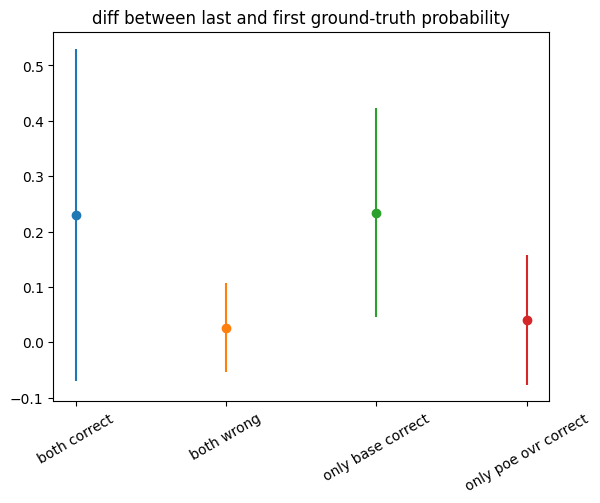

In [114]:
for i, (name, _ids) in enumerate(zip(['both_correct', 'both_wrong', 'only_base_correct', 'only_poe_ovr_correct'], [both_correct_ids, both_incorrect_ids, only_base_correct_ids, only_poe_ovr_correct_ids])):
    diffs = probs[L - 1, _ids, targets[_ids]] - probs[0, _ids, targets[_ids]]
    plt.errorbar(i, diffs.mean(), yerr=diffs.std(), fmt='o', label=name)
plt.xticks([0, 1, 2, 3], ['both correct', 'both wrong', 'only base correct', 'only poe ovr correct'], rotation=30)
plt.title('diff between last and first ground-truth probability')
plt.show()

# 10 Zero Time Waste

In [11]:
ztw_dict = {}
for name, _preds in zip(["base", "PoE-OVR"], [preds, preds_poe_ovr_break_ties_generalized]):
    hindsight_count = {l + 1: 0 for l in range(L)}
    for l in range(1, L):
        incorrect_count = 0
        for n in range(N):
            if _preds[l][n] != targets[n]: 
                incorrect_count += 1   
                preds_prev = [_preds[_l][n] for _l in range(l)]
                if targets[n] in preds_prev:
                    hindsight_count[l + 1] += 1
        hindsight_count[l + 1] = hindsight_count[l + 1] / incorrect_count
    ztw_dict[name] = hindsight_count

In [12]:
ztw_dict['base']

{1: 0,
 2: 0.12391005048187242,
 3: 0.2143128562381254,
 4: 0.2651008931524975,
 5: 0.28879430644711135}

In [13]:
ztw_dict['PoE-OVR']

{1: 0,
 2: 0.06884701300189014,
 3: 0.1085221832109799,
 4: 0.1399113379903278,
 5: 0.1583508036338225}

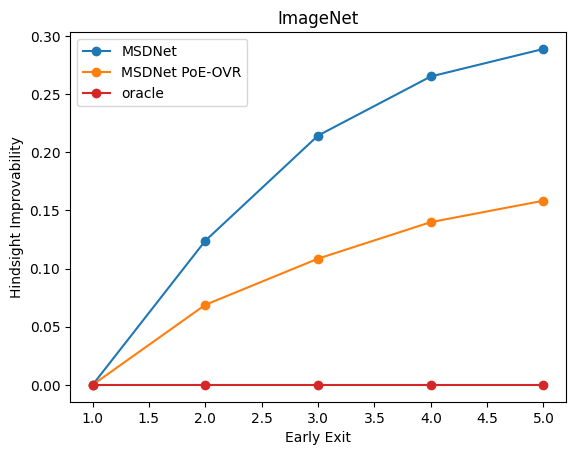

In [17]:
plt.plot(list(ztw_dict['base'].keys()),list(ztw_dict['base'].values()), label='MSDNet', marker='o')
plt.plot(list(ztw_dict['PoE-OVR'].keys()), list(ztw_dict['PoE-OVR'].values()), label='MSDNet PoE-OVR', marker='o')
plt.plot(list(ztw_dict['PoE-OVR'].keys()), [0.] * L, label='oracle', marker='o', color='tab:red')
plt.xlabel('Early Exit')
plt.ylabel('Hindsight Improvability')
plt.legend()
plt.title(f'{ARGS.data}')
plt.show()

# 11 Budgeted Batch Classification

In [6]:
probs.max(dim=2).values.median(dim=1).values

tensor([0.5325, 0.6866, 0.7585, 0.7849, 0.8353])

In [19]:
# thres_arr = probs.max(dim=2).values.median(dim=1).values
thres_arr = np.arange(0.25, 0.98, 0.02)

In [20]:
thres_arr

array([0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43, 0.45,
       0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65, 0.67,
       0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87, 0.89,
       0.91, 0.93, 0.95, 0.97])

In [21]:
probs_poe_ovr_break_ties_generalized.max(dim=2).values.median(dim=1).values

tensor([0.0032, 0.0078, 0.0207, 0.0542, 0.1359], dtype=torch.float32)

In [29]:
# thres_arr_poe_ovr = probs_poe_ovr_break_ties_generalized.max(dim=2).values.median(dim=1).values
# thres_arr_poe_ovr = np.arange(0.003, 0.15, 0.0025)
thres_arr_poe_ovr = np.concatenate([np.arange(0.003, 0.06, 0.00125), np.arange(0.06, 0.15, 0.005)])

In [30]:
thres_arr_poe_ovr

array([0.003  , 0.00425, 0.0055 , 0.00675, 0.008  , 0.00925, 0.0105 ,
       0.01175, 0.013  , 0.01425, 0.0155 , 0.01675, 0.018  , 0.01925,
       0.0205 , 0.02175, 0.023  , 0.02425, 0.0255 , 0.02675, 0.028  ,
       0.02925, 0.0305 , 0.03175, 0.033  , 0.03425, 0.0355 , 0.03675,
       0.038  , 0.03925, 0.0405 , 0.04175, 0.043  , 0.04425, 0.0455 ,
       0.04675, 0.048  , 0.04925, 0.0505 , 0.05175, 0.053  , 0.05425,
       0.0555 , 0.05675, 0.058  , 0.05925, 0.06   , 0.065  , 0.07   ,
       0.075  , 0.08   , 0.085  , 0.09   , 0.095  , 0.1    , 0.105  ,
       0.11   , 0.115  , 0.12   , 0.125  , 0.13   , 0.135  , 0.14   ,
       0.145  ])

In [37]:
len(thres_arr), len(thres_arr_poe_ovr)

(37, 64)

In [33]:
# q = 0.007
# _probs = probs_poe_ovr_break_ties_generalized

# q = 0.5325
# _probs = probs

budget_dict = {name: [] for name in ['base', 'PoE-OVR']}
for name, _thres_arr, _probs in zip(['base', 'PoE-OVR'], [thres_arr, thres_arr_poe_ovr], [probs, probs_poe_ovr_break_ties_generalized]):
    for thres in _thres_arr:
        _preds_terminated = []
        for n in range(N):
            exited = False
            for l in range(L):
                if _probs[l, n, :].max() >= thres:
                    _preds_terminated.append((l+ 1, _probs[l, n, :].argmax()))
                    exited = True
                    break
            if not exited:
                _preds_terminated.append((L, _probs[L - 1, n, :].argmax()))
        budget_dict[name].append((float((torch.stack([x[1] for x in _preds_terminated]) == targets).sum() / N), np.mean([x[0] for x in _preds_terminated]), thres))

In [34]:
# budget_dict['base']

In [35]:
# budget_dict['PoE-OVR']

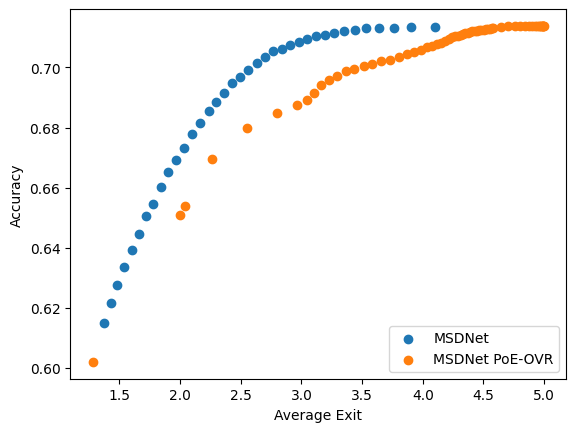

In [36]:
plt.scatter([x[1] for x in budget_dict['base']], [x[0] for x in budget_dict['base']], label='MSDNet', marker='o')
plt.scatter([x[1] for x in budget_dict['PoE-OVR']], [x[0] for x in budget_dict['PoE-OVR']], label='MSDNet PoE-OVR', marker='o')
# plt.scatter([1], [1], label='oracle', marker='o', color='tab:red')
plt.xlabel('Average Exit')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

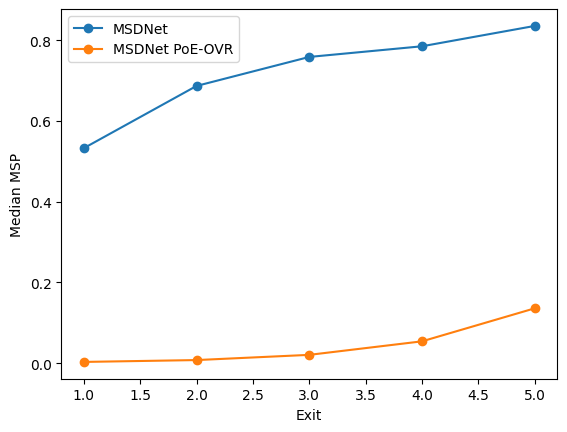

In [38]:
plt.plot([l + 1 for l in range(L)], probs.max(dim=2).values.median(dim=1).values, label='MSDNet', marker='o')
plt.plot([l + 1 for l in range(L)], probs_poe_ovr_break_ties_generalized.max(dim=2).values.median(dim=1).values, label='MSDNet PoE-OVR', marker='o')
plt.legend()
plt.xlabel('Exit')
plt.ylabel('Median MSP')
plt.show()

In [7]:
probs.max(dim=2).values.median(dim=1).values[1:] / probs.max(dim=2).values.median(dim=1).values[:-1]

tensor([1.2894, 1.1046, 1.0348, 1.0642])

In [8]:
probs_poe_ovr_break_ties_generalized.max(dim=2).values.median(dim=1).values[1:] / probs_poe_ovr_break_ties_generalized.max(dim=2).values.median(dim=1).values[:-1]

tensor([2.4439, 2.6593, 2.6199, 2.5093])

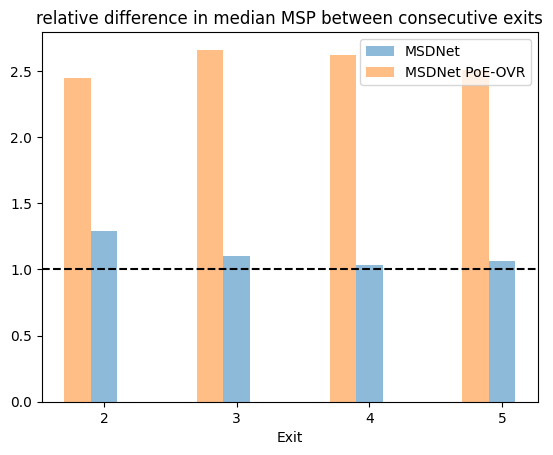

In [16]:
plt.bar([l + 1 for l in range(1, L)], probs.max(dim=2).values.median(dim=1).values[1:] / probs.max(dim=2).values.median(dim=1).values[:-1], width=0.2, label='MSDNet', alpha=0.5)
plt.bar([l + 1 - 0.2 for l in range(1, L)], probs_poe_ovr_break_ties_generalized.max(dim=2).values.median(dim=1).values[1:] / probs_poe_ovr_break_ties_generalized.max(dim=2).values.median(dim=1).values[:-1], width=0.2, label='MSDNet PoE-OVR', alpha=0.5)
plt.xticks([l + 1 for l in range(1, L)])
plt.title('relative difference in median MSP between consecutive exits')
plt.axhline(y=1., linestyle='--', color='black')
plt.xlabel('Exit')
plt.legend()
plt.show()

## 11.1 different thresholds per exit

In [19]:
T = 2.
probs_poe_ovr_break_ties_generalized_temp = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.array([1. ,2., 3., 4., 5.]) / 5.)) * T)
preds_poe_ovr_break_ties_generalized_temp = {i: torch.argmax(probs_poe_ovr_break_ties_generalized_temp, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized_temp = [(targets == preds_poe_ovr_break_ties_generalized_temp[i]).sum() / len(targets) for i in range(L)]

In [20]:
probs_poe_ovr_break_ties_generalized_adapt_thres = np.concatenate([np.nan_to_num(get_probs_ovr_poe_w_adaptive_threshold(logits=logits[:, n, :], weights=(np.arange(1, L + 1, 1, dtype=float) / L), thres_metric=2.5)) for n in range(N)], axis=1)
probs_poe_ovr_break_ties_generalized_adapt_thres = torch.tensor(probs_poe_ovr_break_ties_generalized_adapt_thres)

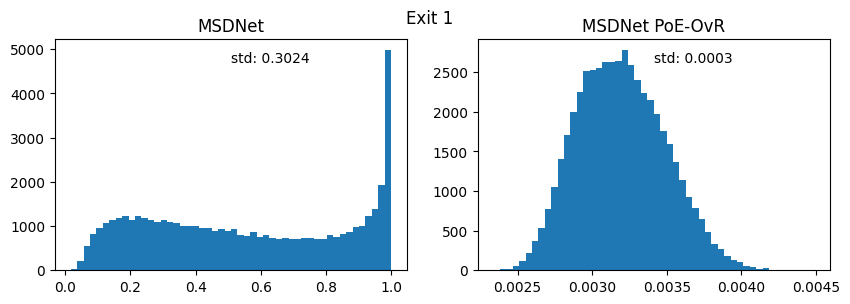

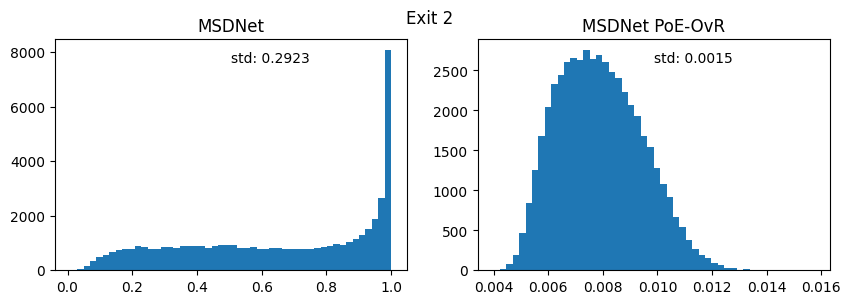

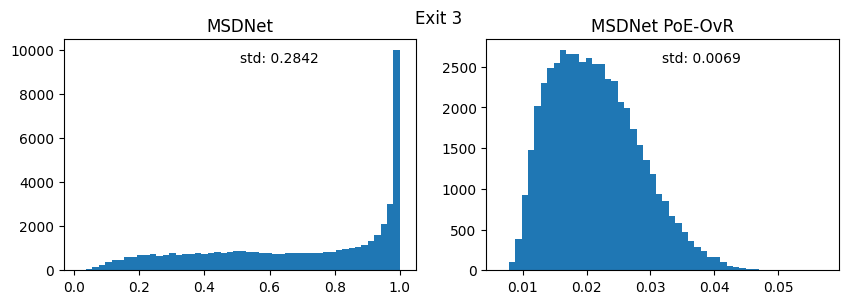

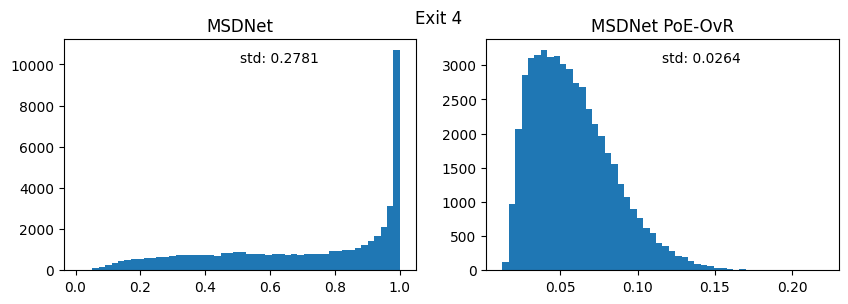

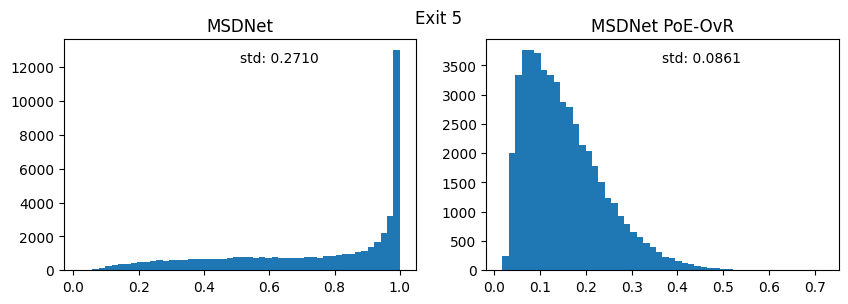

In [13]:
_probs = probs.max(dim=2).values
_probs_poe_ovr = probs_poe_ovr_break_ties_generalized.max(dim=2).values
for l in range(L):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].hist(_probs[l, :].flatten(), bins=50, label='MSDNet')
    ax[0].text(0.5, 0.9, 'std: {:.4f}'.format(_probs[l, :].std()), transform=ax[0].transAxes)
    ax[1].hist(_probs_poe_ovr[l, :].flatten(), bins=50, label='MSDNet PoE-OVR')
    ax[1].text(0.5, 0.9, 'std: {:.4f}'.format(_probs_poe_ovr[l, :].std()), transform=ax[1].transAxes)
    ax[0].set_title('MSDNet')
    ax[1].set_title('MSDNet PoE-OvR')
    fig.suptitle('Exit {}'.format(l + 1))
    plt.show()

In [21]:
quantiles = np.arange(0.1, 1., 0.05)

thres_arr_hetero = {q: [] for q in quantiles}
thres_arr_hetero_poe_ovr = {q: [] for q in quantiles}
thres_arr_hetero_poe_ovr_temp = {q: [] for q in quantiles}
_thres_arr_hetero_poe_ovr_adapt_thres = {q: [] for q in quantiles}
_probs = probs.max(dim=2).values
_probs_poe_ovr = probs_poe_ovr_break_ties_generalized.max(dim=2).values
_probs_poe_ovr_temp = probs_poe_ovr_break_ties_generalized_temp.max(dim=2).values
_probs_poe_ovr_adapt_thres = probs_poe_ovr_break_ties_generalized_adapt_thres.max(dim=2).values
for l in range(L):
    for q in quantiles:
        thres_arr_hetero[q].append(np.quantile(_probs[l, :].flatten(), q))
        thres_arr_hetero_poe_ovr[q].append(np.quantile(_probs_poe_ovr[l, :].flatten(), q))
        thres_arr_hetero_poe_ovr_temp[q].append(np.quantile(_probs_poe_ovr_temp[l, :].flatten(), q))
        _thres_arr_hetero_poe_ovr_adapt_thres[q].append(np.quantile(_probs_poe_ovr_adapt_thres[l, :].flatten(), q))

In [22]:
budget_dict_hetero = {name: [] for name in ['base', 'PoE-OvR', 'PoE-OvR temp', 'PoE-OvR adapt-thres']}
for name, _thres_arr, _probs in zip(['base', 'PoE-OvR', 'PoE-OvR temp', 'PoE-OvR adapt-thres'], 
                                    [thres_arr_hetero, thres_arr_hetero_poe_ovr, thres_arr_hetero_poe_ovr_temp, _thres_arr_hetero_poe_ovr_adapt_thres], 
                                    [probs, probs_poe_ovr_break_ties_generalized, probs_poe_ovr_break_ties_generalized_temp, probs_poe_ovr_break_ties_generalized_adapt_thres]):
    for thres_quantile in _thres_arr.keys():
        _preds_terminated = []
        for n in range(N):
            exited = False
            for l in range(L):
                if _probs[l, n, :].max() >= _thres_arr[thres_quantile][l]:
                    _preds_terminated.append((l+ 1, _probs[l, n, :].argmax()))
                    exited = True
                    break
            if not exited:
                _preds_terminated.append((L, _probs[L - 1, n, :].argmax()))
        budget_dict_hetero[name].append((float((torch.stack([x[1] for x in _preds_terminated]) == targets).sum() / N), np.mean([x[0] for x in _preds_terminated]), thres_quantile))

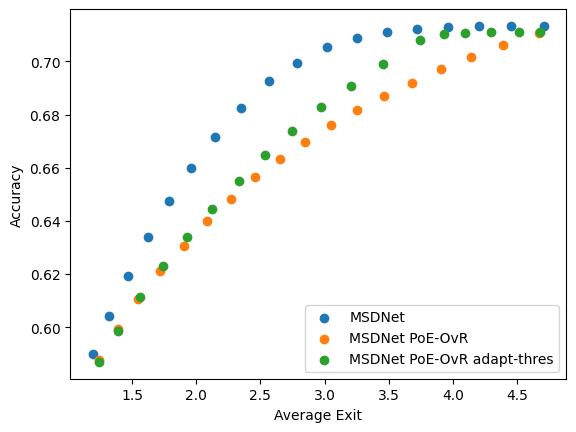

In [25]:
plt.scatter([x[1] for x in budget_dict_hetero['base']], [x[0] for x in budget_dict_hetero['base']], label='MSDNet', marker='o')
plt.scatter([x[1] for x in budget_dict_hetero['PoE-OvR']], [x[0] for x in budget_dict_hetero['PoE-OvR']], label='MSDNet PoE-OvR', marker='o')
# plt.scatter([x[1] for x in budget_dict_hetero['PoE-OvR temp']], [x[0] for x in budget_dict_hetero['PoE-OvR temp']], label='MSDNet PoE-OvR temp', marker='o')
plt.scatter([x[1] for x in budget_dict_hetero['PoE-OvR adapt-thres']], [x[0] for x in budget_dict_hetero['PoE-OvR adapt-thres']], label='MSDNet PoE-OvR adapt-thres', marker='o')
# plt.scatter([1], [1], label='oracle', marker='o', color='tab:red')
plt.xlabel('Average Exit')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# 12 Learn vs Forget

In [23]:
learn_dict = {}
for name, _preds, _acc in zip(['base', 'PoE-OvR'], [preds, preds_poe_ovr_break_ties_generalized], [acc, acc_poe_ovr_break_ties_generalized]):
    correct_ids = []
    for n in range(N):
        preds_all = [_preds[l][n] for l in range(L)]
        if targets[n] in preds_all:
            correct_ids.append((n, preds_all.index(targets[n])))
    
    print(len(correct_ids) / N, float(_acc[-1]), float(len(correct_ids)  / N - _acc[-1]))

    learn_dict[name] = correct_ids


0.79614 0.7133600115776062 0.08278000354766846
0.75912 0.7138000130653381 0.045319974422454834


In [20]:
sorted(Counter([x[1] + 1 for x in learn_dict['base']]).items())

[(1, 28315), (2, 6412), (3, 2866), (4, 1298), (5, 915)]

In [17]:
Counter([x[1] + 1 for x in learn_dict['PoE-OvR']])

Counter({1: 28316, 4: 1160, 2: 5427, 3: 2292, 5: 761})

In [57]:
forget_dict = {}
for name, _preds, _acc in zip(['base', 'PoE-OvR'], [preds, preds_poe_ovr_break_ties_generalized], [acc, acc_poe_ovr_break_ties_generalized]):
    forget_ids = []
    for n in range(N):
        for l in range(1, L):
            # if _preds[l][n] != targets[n]:
            #     preds_prev = [_preds[_l][n] for _l in range(l)]
            #     if targets[n] in preds_prev:
            #         forget_ids.append((n, l))
            #         break

            if _preds[l][n] != targets[n] and _preds[l - 1][n] == targets[n]:
                forget_ids.append((n, l))
                break

            # if _preds[l][n] != targets[n]:
            #     preds_prev = set([int(_preds[_l][n]) for _l in range(l)])
            #     # print(preds_prev, len(preds_prev), targets[n], float(targets[n]) in preds_prev)
            #     if int(targets[n]) in preds_prev and len(preds_prev) == 1:
            #         forget_ids.append((n, l))
            #         break

    forget_dict[name] = forget_ids

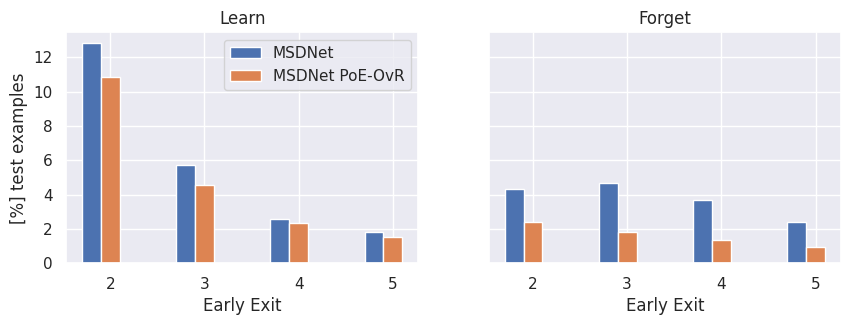

In [61]:
sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

ax[0].set_title('Learn')
ax[1].set_title('Forget')

ax[0].set_ylabel('[%] test examples')
ax[0].set_xlabel('Early Exit')
ax[1].set_xlabel('Early Exit')

ax[0].bar(list(Counter([x[1] + 1 - 0.2 for x in learn_dict['base']]).keys())[1:], [(x / N) * 100 for x in list(Counter([x[1] + 1 for x in learn_dict['base']]).values())][1:], width=0.2, label='MSDNet')
ax[0].bar(list(Counter([x[1] + 1 for x in learn_dict['PoE-OvR']]).keys())[1:], [(x / N) * 100 for x in list(Counter([x[1] + 1 for x in learn_dict['PoE-OvR']]).values())][1:], width=0.2, label='MSDNet PoE-OvR')
ax[0].set_xticks(list(range(2, L + 1)))
ax[0].legend()

ax[1].bar(list(Counter([x[1] + 1 - 0.2 for x in forget_dict['base']]).keys()), [(x / N) * 100 for x in list(Counter([x[1] + 1 for x in forget_dict['base']]).values())], width=0.2, label='MSDNet')
ax[1].bar(list(Counter([x[1] + 1 for x in forget_dict['PoE-OvR']]).keys()), [(x / N) * 100 for x in list(Counter([x[1] + 1 for x in forget_dict['PoE-OvR']]).values())], width=0.2, label='MSDNet PoE-OvR')
ax[1].set_xticks(list(range(2, L + 1)))

plt.show()

# 13 Stateful Anytime Prediction

In [31]:
_probs = probs
# _probs = probs_poe_ovr_break_ties_generalized

_preds = []
for n in range(N):
    preds_all = []
    max_prob_all, pred_all = 0., None
    for l in range(L):
        _max_prob, _pred = _probs[l, n, :].max(), _probs[l, n, :].argmax()
        if _max_prob >= max_prob_all:
            max_prob_all = _max_prob
            pred_all = _pred
        preds_all.append(pred_all)
    _preds.append(torch.stack(preds_all))

_preds = torch.stack(_preds)


In [32]:
_preds.isnan().any()

tensor(False)

In [33]:
# acc_poe_ovr_break_ties_generalized

In [34]:
acc

[tensor(0.5663),
 tensor(0.6514),
 tensor(0.6842),
 tensor(0.6977),
 tensor(0.7134)]

In [35]:
acc_stateful = [(targets == _preds[:, l]).sum() / N for l in range(L)]

In [36]:
acc_stateful

[tensor(0.5663),
 tensor(0.6427),
 tensor(0.6760),
 tensor(0.6912),
 tensor(0.7044)]

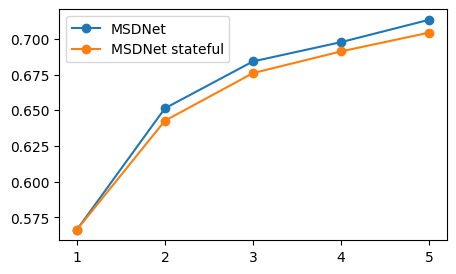

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot([l + 1 for l in range(L)], acc, label='MSDNet', marker='o')
ax.plot([l + 1 for l in range(L)], acc_stateful, label='MSDNet stateful', marker='o')
ax.set_xticks(list(range(1, L + 1)))
plt.legend()
plt.show()

# 14 Adaptive Thresholds in OvR

In [11]:
logits.max(dim=2).values.mean(dim=1)

tensor([14.3815, 15.2075, 15.3679, 15.1379, 14.9025])

In [12]:
K = 2
top_k_logits_diff = (torch.topk(logits, K, dim=2).values[:, :, 0] - torch.topk(logits, K, dim=2).values[:, :, 1])

In [13]:
l = 0
mask_l = (preds_poe_ovr_break_ties_generalized[l] == targets)
top_k_logits_diff[l, mask_l].mean(), top_k_logits_diff[l, ~mask_l].mean(), top_k_logits_diff[l, mask_l].std(), top_k_logits_diff[l, ~mask_l].std()

(tensor(2.8713), tensor(0.8376), tensor(2.3127), tensor(0.8406))

In [22]:
# T = 2.
# probs_poe_ovr_break_ties_generalized_adapt_thres = np.concatenate([np.nan_to_num(get_probs_ovr_poe_w_adaptive_threshold(logits=logits[:, n, :], weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T, thres_easy=12, thres_hard=3)) for n in range(N)], axis=1)
probs_poe_ovr_break_ties_generalized_adapt_thres = np.concatenate([np.nan_to_num(get_probs_ovr_poe_w_adaptive_threshold(logits=logits[:, n, :], weights=(np.arange(1, L + 1, 1, dtype=float) / L), thres_metric=2.5)) for n in range(N)], axis=1)
probs_poe_ovr_break_ties_generalized_adapt_thres = torch.tensor(probs_poe_ovr_break_ties_generalized_adapt_thres)
preds_poe_ovr_break_ties_generalized_adapt_thres = {i: torch.argmax(probs_poe_ovr_break_ties_generalized_adapt_thres, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized_adapt_thres = [(targets == preds_poe_ovr_break_ties_generalized_adapt_thres[i]).sum() / len(targets) for i in range(L)]

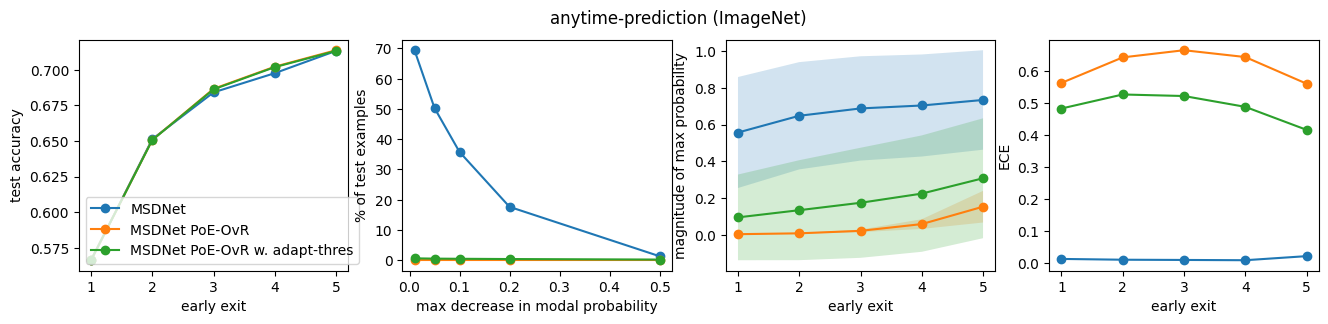

In [23]:
early_exits = [i + 1 for i in range(len(acc))]
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
ax[0].plot(early_exits, acc, label='MSDNet', marker='o',)
ax[0].plot(early_exits, acc_poe_ovr_break_ties_generalized, label='MSDNet PoE-OvR', marker='o',)
ax[0].plot(early_exits, acc_poe_ovr_break_ties_generalized_adapt_thres, label='MSDNet PoE-OvR w. adapt-thres', marker='o')
ax[0].legend()
# ax[0].set_title('anytime-prediction')
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

for _preds, _probs, label in [
                            (preds, probs, 'MSDNet'),
                            (preds_poe_ovr_break_ties_generalized, probs_poe_ovr_break_ties_generalized, 'MSDNet PoE-OvR'),
                            (preds_poe_ovr_break_ties_generalized_adapt_thres, probs_poe_ovr_break_ties_generalized_adapt_thres, 'MSDNet PoE-OvR w. adapt-thres'),
                            ]:
    modal_probs = modal_probs_decreasing(_preds, _probs, layer=L, N=N)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)

    mean_magnitude, std_magnitude = _probs.max(2).values.mean(1), _probs.max(2).values.std(1)

    ax[2].plot(early_exits, mean_magnitude, marker='o', label=label)
    ax[2].fill_between(early_exits, mean_magnitude - std_magnitude, mean_magnitude + std_magnitude, alpha=0.2)

    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
    ax[3].plot(early_exits, ece, marker='o', label=label)

ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')

ax[2].set_xlabel('early exit')
ax[2].set_ylabel('magnitude of max probability')

ax[3].set_xlabel('early exit')
ax[3].set_ylabel('ECE')


plt.suptitle(f'anytime-prediction ({ARGS.data})')
plt.show()

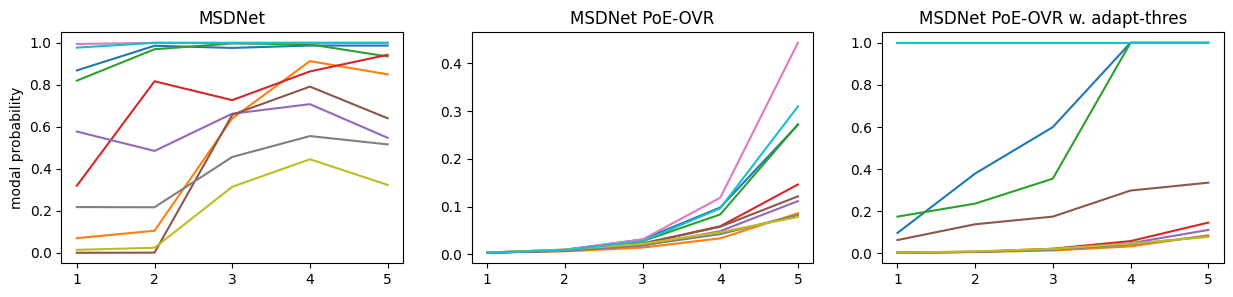

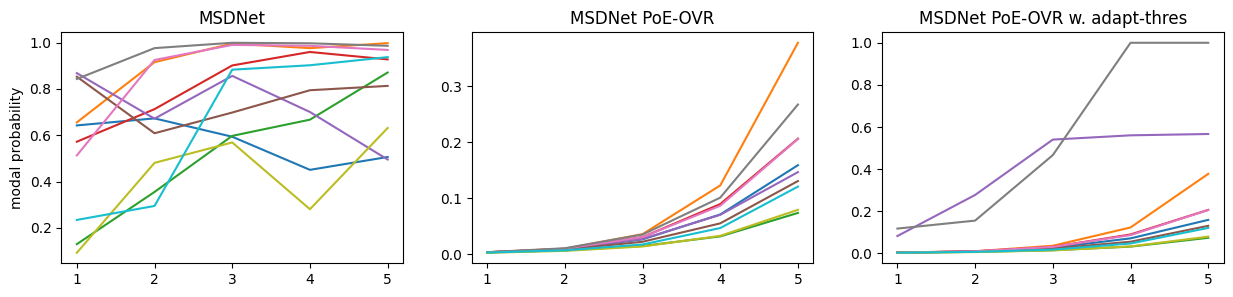

In [17]:
for _ in range(2):
    fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    samples = random.sample(range(10000), 10)
    for i in samples:
        probs_i = probs_poe_ovr_break_ties_generalized[:, i, preds_poe_ovr_break_ties_generalized[L - 1][i]].cpu()
        probs_adapt_thres_i = probs_poe_ovr_break_ties_generalized_adapt_thres[:, i, preds_poe_ovr_break_ties_generalized_adapt_thres[L - 1][i]].cpu()
        probs_i_baseline = probs[:, i, preds[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i_baseline) + 1)), probs_i_baseline, label=f'{i}');
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
        ax[2].plot(list(range(1, len(probs_adapt_thres_i) + 1)), probs_adapt_thres_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    # plt.legend()
    ax[0].set_title('MSDNet')
    ax[1].set_title('MSDNet PoE-OVR')
    ax[2].set_title('MSDNet PoE-OVR w. adapt-thres')
    ax[0].set_ylabel('modal probability')
    plt.show()

# 15 Early-Exit vs Anytime repositioning

In [6]:
correct_trajectories = torch.stack([preds[l] == targets for l in range(L)]).int()
correct_trajectories_poe_ovr = torch.stack([preds_poe_ovr_break_ties_generalized[l] == targets for l in range(L)]).int()

In [7]:
# count number of 1,0 sequences in numpy array
def count_10_sequences(arr):
    count = 0
    for i in range(len(arr) - 1):
        if arr[i] == 1 and arr[i + 1] == 0:
            count += 1
    return count


# get index of first 1 in numpy array
def get_first_1(arr):
    for i in range(len(arr)):
        if arr[i] == 1:
            return i + 1
    return -1

In [8]:
count_10 = [count_10_sequences(correct_trajectories[:, i].numpy()) for i in range(N)]
count_10_poe_ovr = [count_10_sequences(correct_trajectories_poe_ovr[:, i].numpy()) for i in range(N)]

In [9]:
len([x for x in count_10 if x > 0]), len([x for x in count_10_poe_ovr if x > 0])

(7539, 3259)

In [10]:
np.mean(count_10), np.mean(count_10_poe_ovr)

(0.16402, 0.06726)

In [11]:
first_1 = [get_first_1(correct_trajectories[:, i].numpy()) for i in range(N)]
first_1_poe_ovr = [get_first_1(correct_trajectories_poe_ovr[:, i].numpy()) for i in range(N)]

In [12]:
len([x for x in first_1 if x >= 0]), len([x for x in first_1_poe_ovr if x >= 0])

(39807, 37956)

In [13]:
np.mean([x for x in first_1 if x >= 0]), np.mean([x for x in first_1_poe_ovr if x >= 0])

(1.4948375913784009, 1.4356359995784593)

In [16]:
np.corrcoef(np.array([0., 1., 0., 1., 1.]), np.array([1., 2., 3., 4., 5.]))

array([[1.        , 0.57735027],
       [0.57735027, 1.        ]])

In [19]:
np.corrcoef(np.array([0., 0., 0., 0., 0.]), np.array([1., 2., 3., 4., 5.]))

array([[nan, nan],
       [nan,  1.]])

In [18]:
corr_coef = []
corr_coef_poe_ovr = []
for n in range(N):
    corr_coef.append(np.corrcoef(correct_trajectories[:, n].numpy(), np.arange(1, L + 1))[0, 1])
    corr_coef_poe_ovr.append(np.corrcoef(correct_trajectories_poe_ovr[:, n].numpy(), np.arange(1, L + 1))[0, 1])


/home/metod/miniconda3/envs/msdnet/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/metod/miniconda3/envs/msdnet/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [20]:
corr_coef

[-0.8660254037844386,
 0.0,
 0.5773502691896257,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.8660254037844386,
 nan,
 0.7071067811865474,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.7071067811865474,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.7071067811865474,
 nan,
 nan,
 0.7071067811865474,
 nan,
 nan,
 nan,
 nan,
 0.7071067811865474,
 0.3535533905932737,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.0,
 -0.28867513459481287,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.7071067811865474,
 nan,
 0.8660254037844386,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -0.7071067811865475,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.28867513459481287,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.8660254037844386,
 nan,
 0.7071067811865474,
 0.28867513459481287,
 nan,
 nan,
 0.8660254037

In [21]:
correct_trajectories.sum() / (correct_trajectories.shape[0] * correct_trajectories.shape[1]), correct_trajectories_poe_ovr.sum() / (correct_trajectories_poe_ovr.shape[0] * correct_trajectories_poe_ovr.shape[1])

(tensor(0.6626), tensor(0.6640))